# Chieff-z correlated simulations mass-spin inference
#### Code: [gppop/spin-dev](https://github.com/AnaryaRay1/gppop/tree/spin-dev)

#### Contents 

- [Preamble](#Preamble), need to run.
- [Prepare Input](#Prepare-input)
- [Run Inference](#Run-inference)
- [GP sanity checks](#GP-sanity-checks)



# Preamble

In [ ]:
import numpy as np
import pandas as pd
import h5py
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator,LogLocator,NullFormatter)
from matplotlib.colors import LogNorm
import glob
import yaml
from astropy.cosmology import Planck15,z_at_value
from astropy import units as u
from scipy.interpolate import interp1d

In [3]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['font.family'] = 'Times New Roman'
matplotlib.rcParams['font.sans-serif'] = ['Bitstream Vera Sans']
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['axes.unicode_minus'] = False

import seaborn as sns
sns.set_context('talk')
sns.set_style('ticks')
sns.set_palette('colorblind')
colors=sns.color_palette('colorblind')
fs=80

In [4]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

In [5]:
import arviz as az

In [6]:
import gppop
gppop.__file__

'/home/anarya.ray/gppop-prod/spindev/gppop/src/gppop/__init__.py'

In [7]:
%load_ext autoreload
%autoreload 2
from gwdistributions.distributions.spin.effective import IsotropicUniformMagnitudeChiEffGivenComponentMass, AlignedUniformMagnitudeChiEffGivenComponentMass

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/anarya.ray/gppop-prod/spindev/gw-distributions/gwdistributions/transforms/location.py:10: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(True)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  from lal.lal import GreenwichMeanSiderealTime as GMST


In [8]:
from gppop.core import Utils_spins,Utils,Vt_Utils_spins, Rates_spins

/cvmfs/software.igwn.org/conda/envs/igwn-py39-20240305/compiler_compat/ld: warning: libgfortran.so.5, needed by /usr/lib64/libopenblas.so, not found (try using -rpath or -rpath-link)
/cvmfs/software.igwn.org/conda/envs/igwn-py39-20240305/compiler_compat/ld: /usr/lib64/libopenblas.so: undefined reference to `expf@GLIBC_2.27'
/cvmfs/software.igwn.org/conda/envs/igwn-py39-20240305/compiler_compat/ld: /usr/lib64/libopenblas.so: undefined reference to `_gfortran_concat_string@GFORTRAN_8'
/cvmfs/software.igwn.org/conda/envs/igwn-py39-20240305/compiler_compat/ld: /usr/lib64/libopenblas.so: undefined reference to `powf@GLIBC_2.27'
/cvmfs/software.igwn.org/conda/envs/igwn-py39-20240305/compiler_compat/ld: /usr/lib64/libopenblas.so: undefined reference to `logf@GLIBC_2.27'
/cvmfs/software.igwn.org/conda/envs/igwn-py39-20240305/compiler_compat/ld: /usr/lib64/libopenblas.so: undefined reference to `_gfortran_etime@GFORTRAN_8'
collect2: error: ld returned 1 exit status


WARN: Could not locate executable armflang


In [61]:
mbins = np.array([  5. ,   6.5 ,  7.5 , 12.5 , 15. ,  17.5,  30.,   40.,   50.,   60., 80., 100. ])
chi_bins = np.array([-0.4  , -0.2  ,  0.   ,  0.1  ,  0.15, 0.25 ,  0.35  ,  0.4  ,
        0.6  ,  0.8  ])

In [62]:
utils = Utils_spins(mbins,chi_bins,kappa=3.0)

In [15]:
Zs = np.linspace(0.,10,1000)
DLs = Planck15.luminosity_distance(Zs).value
z_interp = interp1d(DLs,Zs)

# Prepare-input

In [16]:
import glob
import json
import pandas as pd
mdc_dir = '/home/anarya.ray/gppop-prod/MDC_from_scratch/outdir_O3/'
posteriors = glob.glob(mdc_dir+'pop2b_chi1chi2right/*/bbh_result.json')

N_samples = 1e6
N = []
for i,fle in enumerate(posteriors):
    
    with open(fle,'r') as jf:
        data = json.load(jf)
        posterior = data['posterior']['content']
        if N_samples>len(posterior['chirp_mass']):
            N_samples = len(posterior['chirp_mass'])
    N.append(len(posterior['chirp_mass']))

print(posterior.keys())
print(N_samples,min(N),max(N),len(posteriors))

dict_keys(['mass_ratio', 'chirp_mass', 'theta_jn', 'chi_1', 'chi_2', 'luminosity_distance', 'dec', 'ra', 'psi', 'phase', 'geocent_time', 'log_likelihood', 'log_prior', 'reference_frequency', 'waveform_approximant', 'minimum_frequency', 'total_mass', 'mass_1', 'mass_2', 'a_1', 'cos_tilt_1', 'a_2', 'cos_tilt_2', 'phi_jl', 'phi_12', 'tilt_1', 'tilt_2', 'H1_log_likelihood', 'L1_log_likelihood', 'V1_log_likelihood', 'H1_matched_filter_snr', 'H1_optimal_snr', 'L1_matched_filter_snr', 'L1_optimal_snr', 'V1_matched_filter_snr', 'V1_optimal_snr', 'symmetric_mass_ratio', 'iota', 'spin_1x', 'spin_1y', 'spin_1z', 'spin_2x', 'spin_2y', 'spin_2z', 'phi_1', 'phi_2', 'chi_eff', 'chi_1_in_plane', 'chi_2_in_plane', 'chi_p', 'redshift', 'comoving_distance', 'mass_1_source', 'mass_2_source', 'chirp_mass_source', 'total_mass_source'])
3201 3201 5338 275


In [17]:
%reload_ext autoreload
spin_prior = AlignedUniformMagnitudeChiEffGivenComponentMass()
spin_prior._init_values(max_spin_magnitude=0.99)

In [18]:
posterior_samples_all = np.zeros((len(posteriors),N_samples,4))
spin_priors = [ ]
np.random.seed(2**31-78)
n=0
for i,fle in enumerate(posteriors):
    
    with open(fle,'r') as jf:
        data = json.load(jf)
        m1= np.array(data['posterior']['content']['mass_1_source'])
        m2 = np.array(data['posterior']['content']['mass_2_source'])
        z = np.array(data['posterior']['content']['redshift'])
        chi_eff =np.array(data['posterior']['content']['chi_eff'])
        time = data['injection_parameters']['geocent_time']
        
        indices = np.random.choice(len(m1),size=N_samples,replace=False)
        
        spin_priors.append(np.exp(spin_prior._logprob(chi_eff,
                                                      m1,
                                                      m2,0.99))[indices])
        posterior_samples_all[n,:,:] = np.array([m1,m2,z,chi_eff]).T[indices,:]
        n+=1

spin_priors = np.array(spin_priors)
print(posterior_samples_all.shape,spin_priors.shape)

(275, 3201, 4) (275, 3201)


In [63]:
weights = [ ]
for i,posterior_samples_this_event in enumerate(posterior_samples_all):
    weights.append(utils.arraynd_to_tril(utils.compute_weights(posterior_samples_this_event,chi_prior=spin_priors[i])))
    if i%20==0:
        print(i)

0
20
40
60
80
100
120
140
160
180
200
220
240
260


In [64]:
weights = np.array(weights)

In [65]:
weights.shape

(275, 594)

In [66]:
wts_sum = np.sum(weights,axis=0)

In [67]:
print(len(wts_sum))

594


(11, 11, 9)


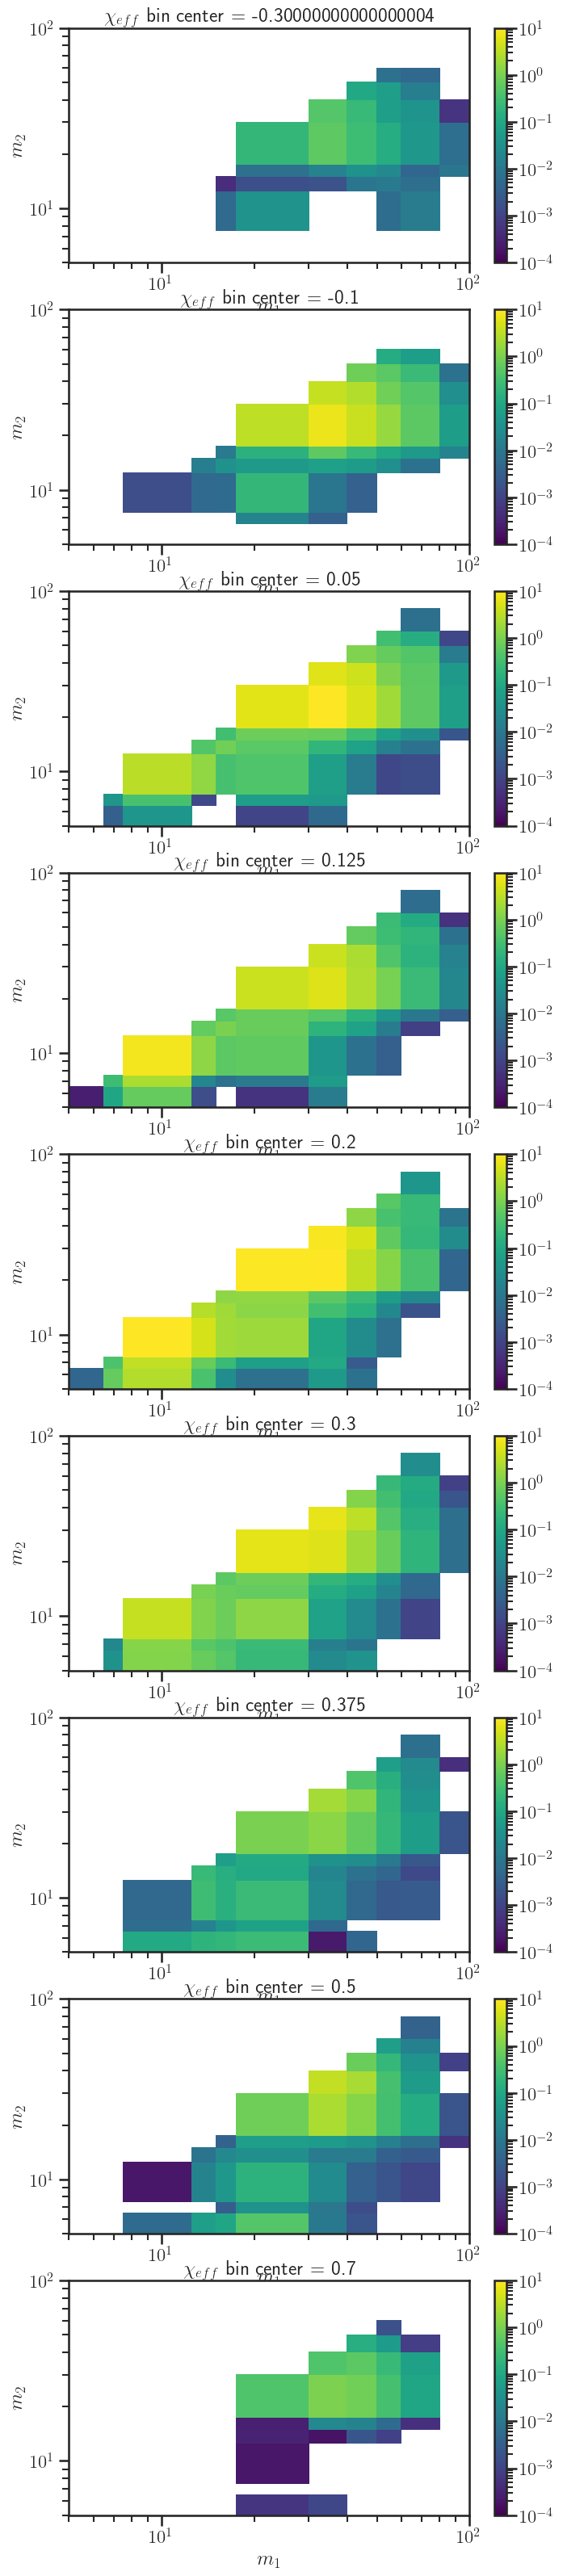

In [68]:
fig,axes = plt.subplots(len(chi_bins)-1,figsize=(8,40))
wts_sum = np.sum(weights,axis=0)
w= utils.construct_1dtond_matrix(len(mbins)-1,wts_sum,nbins_chi=len(chi_bins)-1)
print(w.shape)
for i in range(len(chi_bins)-1):
        ax = axes[i]
        ax.set_title(r'$\chi_{eff}$ bin center = '+str(0.5*(chi_bins[i+1]+chi_bins[i])))
        matrix1 = w[:,:,i]
        if(matrix1.min()==matrix1.max()):
            continue

        pc = ax.pcolor(mbins,mbins,matrix1.T,norm=LogNorm(vmin=1e-4,vmax=10),cmap='viridis')
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xlabel(r'$m_1$')
        ax.set_ylabel(r'$m_2$')
        plt.colorbar(pc, ax = ax)
    
plt.show()

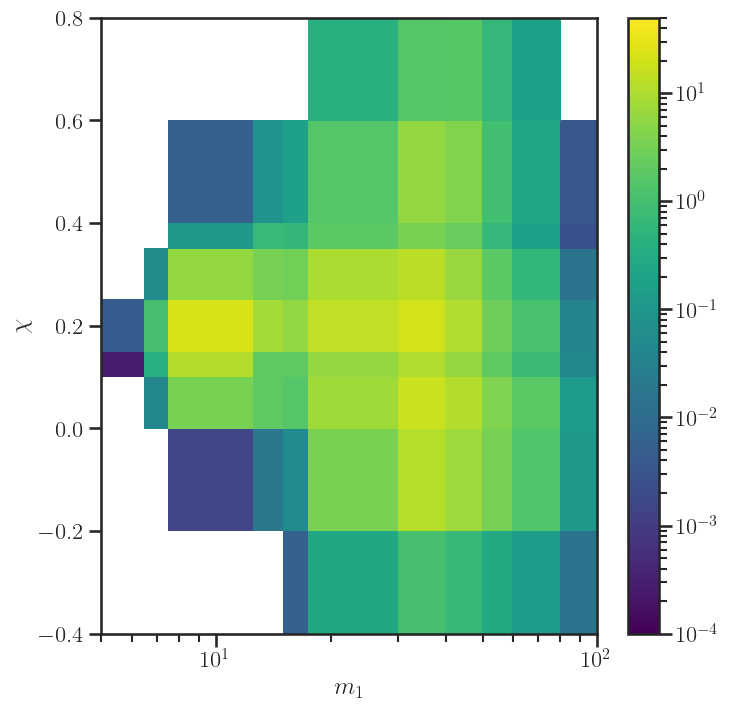

In [70]:
fig,axes = plt.subplots(1,figsize=(8,8))
ax = axes
#ax.set_title(r'$\chi_{eff}$ bin center = '+str(0.5*(mbins[i+1]+mbins[i])))
matrix1 = np.sum(w,axis=1)
# if(matrix1.min()==matrix1.max()):
#     continue

pc = ax.pcolor(mbins,chi_bins,matrix1.T,norm=LogNorm(vmin=1e-4,vmax=50),cmap='viridis')
ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlabel(r'$m_1$')
ax.set_ylabel(r'$\chi$')
plt.colorbar(pc, ax = ax)

In [71]:
np.where(mbins == 30.)

(array([6]),)

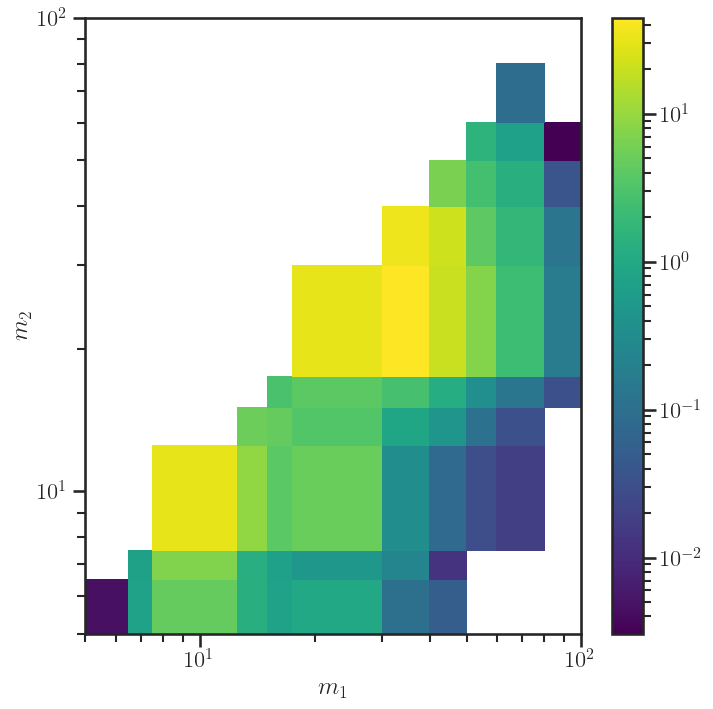

In [75]:
fig,axes = plt.subplots(1,figsize =(8,8))

ax = axes

matrix1 = np.sum(w,axis=-1)

pc = ax.pcolor(mbins,mbins,matrix1.T,norm=LogNorm(vmin=matrix1[matrix1!=0].min(),vmax=matrix1.max()),cmap='viridis')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$m_1$')
ax.set_ylabel(r'$m_2$')
plt.colorbar(pc, ax = ax)

plt.show()

In [83]:
spin_prior = IsotropicUniformMagnitudeChiEffGivenComponentMass()
spin_prior._init_values(max_spin_magnitude=0.99)

In [84]:
config_file = '/home/anarya.ray/gppop-prod/pairing/plpp_mdc.yaml'
with open(config_file, "r") as stream:
    config = yaml.full_load(stream)

In [85]:
config['injection_file']

'/home/anarya.ray/gppop-mdc/3d-clean/o1+o2+o3_bbhpop_real+semianalytic-LIGO-T2100377-v2.hdf5'

In [86]:
inj_dataset = {}
with h5py.File('/home/anarya.ray/gppop-mdc/mdcs/plpp/endo3_bbhpop-LIGO-T2100113-v12.hdf5','r') as hf:
    inj_dataset['analysis_time_s'] = hf.attrs['analysis_time_s'] # years
    inj_dataset['total_generated'] = hf.attrs['total_generated']
    for param,key in config['injection_keys'].items():
            inj_dataset[param] = hf[key][()]

chi_eff = (inj_dataset['mass1_source']*inj_dataset['spin1z']+
           inj_dataset['mass2_source']*inj_dataset['spin2z'])/(inj_dataset['mass1_source']+
                                                                        inj_dataset['mass2_source'])
inj_dataset['p_draw_chi_given_m1m2'] = np.exp(spin_prior._logprob(chi_eff,inj_dataset['mass1_source'],
                                                                  inj_dataset['mass2_source'],0.99))
thresh = 9.0#config['threshold']
thresh_keys = 'optimal_snr_net'#config['threshold_keys']


/home/anarya.ray/gppop-prod/spindev/gw-distributions/gwdistributions/distributions/spin/effective.py:229: RuntimeWarning: invalid value encountered in log
  ans = q*amax*(4 + 2*be.log(amax) - be.log(q**2*amax**2 - (1+q)**2 * chi**2)) \
/home/anarya.ray/gppop-prod/spindev/gw-distributions/gwdistributions/distributions/spin/effective.py:230: RuntimeWarning: invalid value encountered in arctanh
  - 2*(1+q)*chi * be.arctanh((1+q)*chi/(q*amax)) \
/home/anarya.ray/gppop-prod/spindev/gw-distributions/gwdistributions/distributions/spin/effective.py:246: RuntimeWarning: invalid value encountered in arctanh
  - 2*(1+q)*chi*be.arctanh(q*amax/((1+q)*chi)) \
/home/anarya.ray/gppop-prod/spindev/gw-distributions/gwdistributions/distributions/spin/effective.py:247: RuntimeWarning: invalid value encountered in log
  - q*amax*be.log((1+q)**2*chi**2 - q**2*amax**2) \
/home/anarya.ray/gppop-prod/spindev/gw-distributions/gwdistributions/distributions/spin/effective.py:250: RuntimeWarning: invalid value enc

In [87]:
vt_utils = Vt_Utils_spins(mbins,chi_bins,kappa=3)

In [88]:
vt_means,vt_sigmas = vt_utils.compute_VTs(inj_dataset,thresh,key = thresh_keys )

In [89]:
log_bin_centers=utils.generate_log_bin_centers()
tril_deltaLogbin = utils.arraynd_to_tril(utils.deltaLogbin())

In [90]:
vts_nd = utils.construct_1dtond_matrix(len(mbins)-1,vt_means/tril_deltaLogbin,nbins_chi=len(chi_bins)-1)

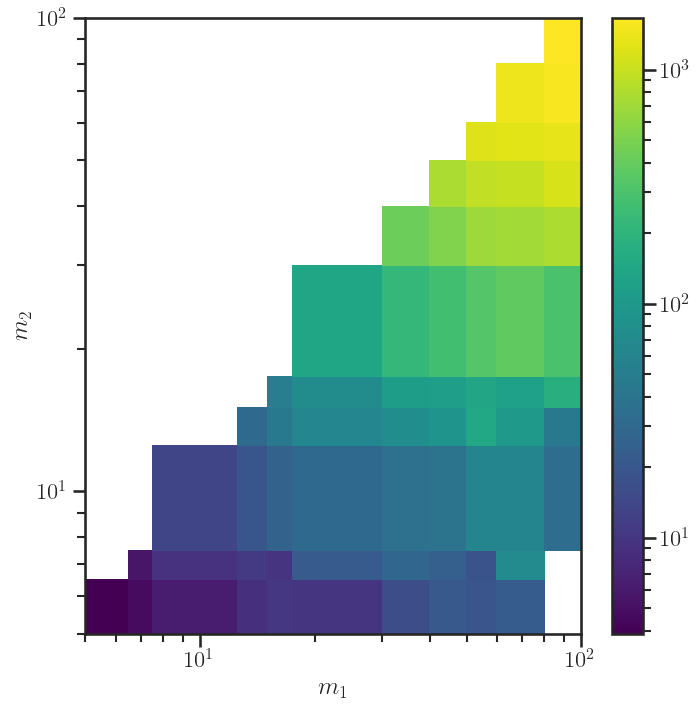

In [91]:
fig,axes = plt.subplots(1,figsize =(8,8))
#for i in range(len(chi_bins)-1):
ax = axes
#ax.set_title(r'$\chi_{eff}$ bin center = '+str(int(1000*0.5*(chi_bins[i+1]+chi_bins[i]))/1000))
matrix1 = np.sum(vts_nd,axis=-1)

pc = ax.pcolor(mbins,mbins,matrix1.T,norm=LogNorm(vmin=matrix1[matrix1!=0].min(),vmax=matrix1.max()),cmap='viridis')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$m_1$')
ax.set_ylabel(r'$m_2$')
plt.colorbar(pc, ax = ax)

plt.show()

(11, 11, 9)


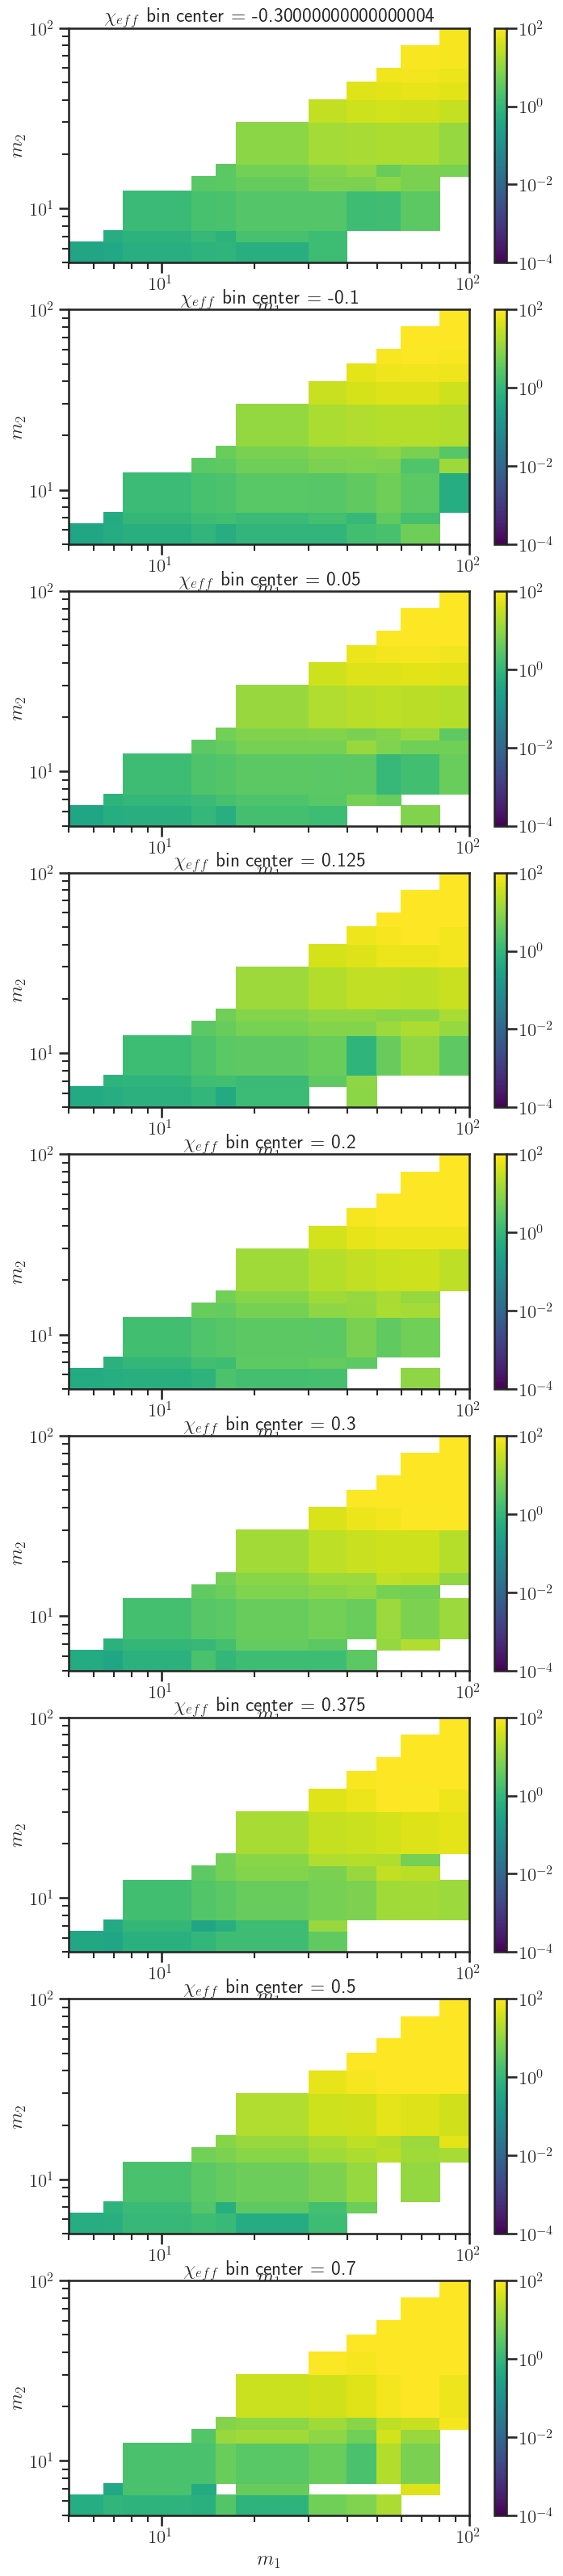

In [92]:
fig,axes = plt.subplots(len(chi_bins)-1,figsize=(8,40))
wts_sum = np.sum(weights,axis=0)
w= utils.construct_1dtond_matrix(len(mbins)-1,wts_sum,nbins_chi=len(chi_bins)-1)
print(w.shape)
for i in range(len(chi_bins)-1):
        ax = axes[i]
        ax.set_title(r'$\chi_{eff}$ bin center = '+str(0.5*(chi_bins[i+1]+chi_bins[i])))
        matrix1 = vts_nd[:,:,i]
        if(matrix1.min()==matrix1.max()):
            continue

        pc = ax.pcolor(mbins,mbins,matrix1.T,norm=LogNorm(vmin=1e-4,vmax=100),cmap='viridis')
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xlabel(r'$m_1$')
        ax.set_ylabel(r'$m_2$')
        plt.colorbar(pc, ax = ax)
    #fig.colorbar()
plt.show()

In [93]:
arg = np.where(matrix1[np.tril_indices(len(matrix1))]==0)[0]
print(arg)


[11 22 29 37 45 55 56 57 58]


In [94]:
nbins_m = len(mbins)-1
nbins_m = int(0.5*nbins_m*(nbins_m+1))
nbins_chi = len(chi_bins)-1
args = np.array([ ])
for i in range(nbins_chi-1):
    args = np.append(args,nbins_m*i+arg)
args=args.astype(int)


In [95]:
log_bin_centers=utils.generate_log_bin_centers()
tril_deltaLogbin = utils.arraynd_to_tril(utils.deltaLogbin())

In [96]:
def interpolate_vts(log_bin_centers,tril_deltaLogbin,tril_vts,arg=None):
        '''
        Function for interpolating VTs over bins that have no injections
        using a GP regressor.
        
        Parameters
        ----------
        
        tril_vts  :: numpy.ndarray
                     1d array containing VT meands or stds to be interpolated.
        
        arg       :: numpy.ndarray
                     1d array containing bin indices at which interpolated
                     VTs need to be calculated.
                     
        Returns
        -------
        
        new_vts  : numpy.ndarray
                   interpolated VTs.
        '''
        if(all(tril_vts>0) or arg is None):
            return tril_vts
        
        vts = tril_vts/tril_deltaLogbin
        X =log_bin_centers[vts!=0]
        y = np.log((vts)[vts!=0])
        kernel = RBF(length_scale=0.3,length_scale_bounds=[0.1,2])
        gp = GaussianProcessRegressor(kernel=kernel,n_restarts_optimizer=5).fit(X,y)
        y_pred = gp.predict(log_bin_centers[arg.astype(int)])
        vt_pred = np.exp(y_pred)
        new_vts = vts.copy()
        new_vts[arg.astype(int)] = vt_pred
        return new_vts*tril_deltaLogbin

In [97]:
interp_vts = interpolate_vts(log_bin_centers,tril_deltaLogbin,vt_means,arg=args)

In [98]:
np.savetxt('weights_pop2b_phenomD_m1m2chi_newbins29.txt',weights)

In [99]:
np.savetxt('vts_m1m2chi_newbins29.txt',interp_vts/tril_deltaLogbin)

In [100]:
np.savetxt('mbins9.txt',mbins)
np.savetxt('chi_bins_new29.txt',chi_bins)

In [101]:
dist_array = np.zeros(int(nbins_m*(nbins_m+1)/2))

chi_bin_centers = log_bin_centers[0::nbins_m,2]
logm_bin_centers = log_bin_centers[:nbins_m,:2]
k=0
for i in range(len(logm_bin_centers)):
    for j in range(i+1):
        dist_array[k] = np.linalg.norm(logm_bin_centers[i]-logm_bin_centers[j])
        k+=1

scale_min = np.log(np.min(dist_array[dist_array!=0.]))
scale_max = np.log(np.max(dist_array))
scale_mean_m = 0.5*(scale_min + scale_max) # chosen to give coverage over the bin-grid
scale_sd_m = (scale_max - scale_min)/4 # fix 3-sigma difference to the sd of the length scale dist

dist_array = np.zeros(int(nbins_chi*(nbins_chi+1)/2))
k=0
for i in range(len(chi_bin_centers)):
    for j in range(i+1):
        dist_array[k] = np.linalg.norm(chi_bin_centers[i]-chi_bin_centers[j])
        k+=1

scale_min = np.log(np.min(dist_array[dist_array!=0.]))
scale_max = np.log(np.max(dist_array))
scale_mean_chi = 0.5*(scale_min + scale_max) # chosen to give coverage over the bin-grid
scale_sd_chi = (scale_max - scale_min)/4 # fix 3-sigma difference to the sd of the length scale dist
print(scale_mean_m,scale_sd_m,scale_mean_chi,scale_sd_chi)

-0.21156493111827712 0.7854109445345605 -1.2951335827229133 0.6475667913614567


In [102]:
np.savetxt('gp_inputs_newbins29.txt',np.array([scale_mean_m,scale_sd_m,scale_mean_chi,scale_sd_chi]))

# Run-inference

# GP-sanity-checks

In [103]:
trace = az.from_netcdf('gppop_posterior_pop2b_PhenomD_newbins29_kappa_corr_multimu_trunc.nc')

In [104]:
trace['posterior'].keys()

KeysView(<xarray.Dataset>
Dimensions:                   (chain: 6, draw: 5000,
                               logn_corr_rotated__dim_0: 594, mu_dim_0: 1,
                               logn_corr_dim_0: 594, logn_tot_dim_0: 594,
                               n_corr_dim_0: 594, n_corr_physical_dim_0: 563)
Coordinates:
  * chain                     (chain) int64 0 1 2 3 4 5
  * draw                      (draw) int64 0 1 2 3 4 ... 4996 4997 4998 4999
  * logn_corr_rotated__dim_0  (logn_corr_rotated__dim_0) int64 0 1 2 ... 592 593
  * mu_dim_0                  (mu_dim_0) int64 0
  * logn_corr_dim_0           (logn_corr_dim_0) int64 0 1 2 3 ... 591 592 593
  * logn_tot_dim_0            (logn_tot_dim_0) int64 0 1 2 3 ... 590 591 592 593
  * n_corr_dim_0              (n_corr_dim_0) int64 0 1 2 3 4 ... 590 591 592 593
  * n_corr_physical_dim_0     (n_corr_physical_dim_0) int64 0 1 2 ... 561 562
Data variables:
    logn_corr_rotated_        (chain, draw, logn_corr_rotated__dim_0) float64 ...
  

In [105]:
N_samples = int(len(trace['posterior']['draw'])*len(trace['posterior']['chain']))

In [106]:
#az.plot_trace(trace,divergences='top')

In [109]:
# trace = az.from_netcdf('gppop_posterior_pop2a_PhenomD_newbins20_kappa_corr.nc')
# az.plot_trace(trace,divergences='top')

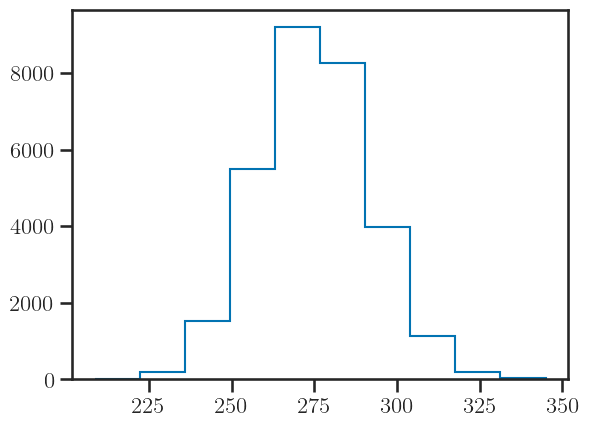

In [110]:
_=plt.hist(trace['posterior']['N_F_exp'].to_numpy().reshape((N_samples,)),histtype='step')
#plt.axvline(len(weights))

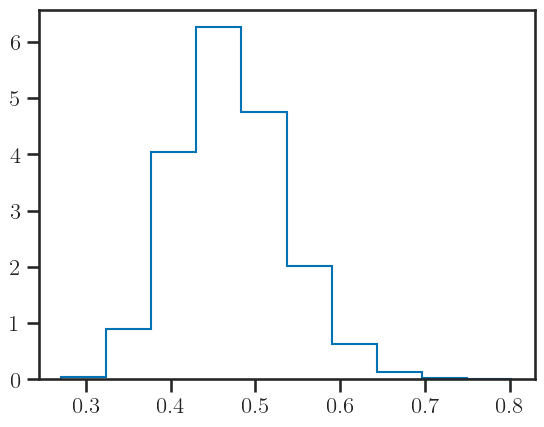

In [111]:
_=plt.hist(trace['posterior']['length_scale_m'].to_numpy().reshape((N_samples,)),histtype='step',density=True)

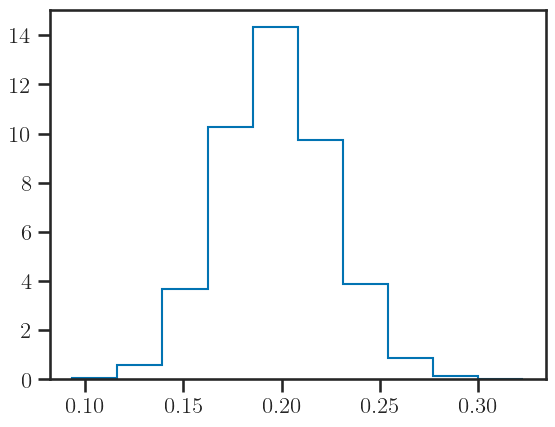

In [112]:
_=plt.hist(trace['posterior']['length_scale_chi'].to_numpy().reshape((N_samples,)),histtype='step',density=True)

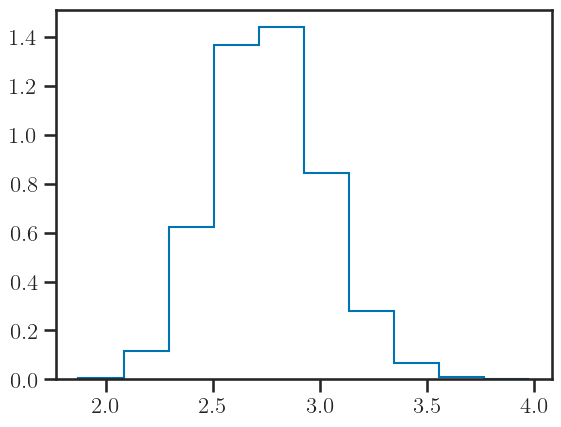

In [113]:
_=plt.hist(trace['posterior']['sigma'].to_numpy().reshape((N_samples,)),histtype='step',density=True)